In [1]:
import numpy as np
from nptyping import NDArray
import random
import numpy.linalg as LA
import matplotlib.pyplot as plt
from typing import List, Set, Dict, Tuple, Optional, Any, Callable
from utils import load_image_to_arr, display_rgb, SVD2D
import os
import zipfile
from PIL import Image
from io import BytesIO ## for Python 3
import cityscapes_helper

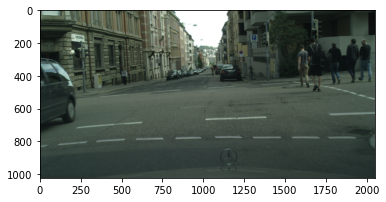

In [3]:


cityscapes_helper.set_visual_data_zip_path(r"C:\Users\Ben\Downloads\leftImg8bit_trainvaltest.zip")
cityscapes_helper.set_semantic_data_zip_path(r"C:\Users\Ben\Downloads\gtFine_trainvaltest.zip")
cityscapes_helper.initialize_tool()

sceneID, img = cityscapes_helper.loadRandomVisualInfo()
display_rgb(img)

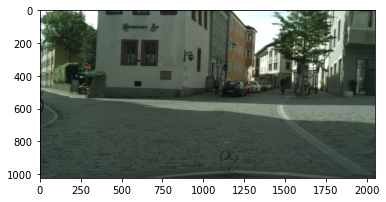

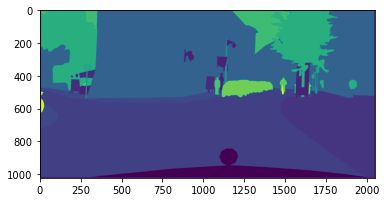

In [6]:
sceneID, (vis_img, sem_img) = cityscapes_helper.loadRandomScene()
display_rgb(vis_img)
fig, ax = plt.subplots()
ax.imshow(sem_img)

In [7]:
def sample_sub_portion_dimensions(h, w, size = 64):
    corner_row = random.randint(0, h - size - 1)
    corner_col = random.randint(0, w - size - 1)
    return ((corner_row, corner_row + size), (corner_col, corner_col + size))

def get_random_image_subportion(img_arr, size = 64):
    h, w = img_arr.shape[0], img_arr.shape[1]
    dim = sample_sub_portion_dimensions(h, w, size)
    lil_img = img_arr[dim[0][0]:dim[0][1], dim[1][0]:dim[1][1]]
    return lil_img

In [18]:
def sample_image_chunks(size, n_chunks_per_image, n_chunks_total) -> List[NDArray[Any]]:
    result: List[NDArray[Any]] = []
    num_images = (n_chunks_total // n_chunks_per_image)
    one_percent = n_chunks_total // 100
    chunki = 0
    for img_i in range(num_images):
        sceneID, vis_img = cityscapes_helper.loadRandomVisualInfo()
        for ci in range(n_chunks_per_image):
            if(chunki % one_percent == 0):
                print("|", end="")
            chunk = get_random_image_subportion(vis_img, size)
            result.append(chunk)
            chunki += 1
    return result



#imgs = sample_image_chunks(16, 20, 3000)

In [19]:
len(imgs)

3000

In [20]:
def extract_pcms_from_images(imgs):
    result = []
    one_percent = len(imgs) // 100
    img_i = 1
    for img in imgs:    
        if(img_i % one_percent == 0):
            print("|", end="")
        img_area_2d = img.shape[0] * img.shape[1]
        colors = img.reshape(img_area_2d, 3)
        colors_mean = np.mean(colors, axis=0)
        colors_mean_rem = colors - colors_mean
        color_svd = SVD2D(colors_mean_rem)
        
        for i in range(2):
            U = color_svd.U[:, i].reshape((img.shape[0], img.shape[1])).astype(np.float32)
            result.append(U)
        img_i += 1
    return result

In [21]:
pcms = extract_pcms_from_images(imgs)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

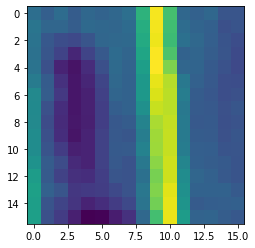

In [80]:
fig, ax = plt.subplots()
ax.imshow(pcms[1200])

In [31]:
def calculate_basis_matrix(size, n_samples):
    pcms_flat = []
    img_chunks = sample_image_chunks(size, 30, n_samples//2)
    print()
    pcms = extract_pcms_from_images(img_chunks)
    for pcm2d in pcms:
        pcms_flat.append(pcm2d.ravel())
    stacked_pcms = np.vstack(pcms_flat)
    pcms_svd = SVD2D(stacked_pcms)
    return pcms_svd.VT

calculate_basis_matrix(64, 5000).shape

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
2490
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

(4096, 4096)

In [33]:
pcm_bases = []
for size in range(16, 256+16, 16):
    basis = calculate_basis_matrix(size, 40000)
    pcm_bases.append(basis)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
19980
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
19980
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
19980
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
19980
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
19980
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

MemoryError: Unable to allocate 6.17 GiB for an array with shape (39960, 20736) and data type float64

In [35]:
len(pcm_bases)

8

In [54]:
for b in pcm_bases:
    dim = int(b.shape[0] ** 0.5)
    print(b.shape)
    with open(f"pcm_bases/dim_{dim}.npy", "wb") as f:
        np.save(f, b[:256].astype(np.float32))

(256, 256)
(1024, 1024)
(2304, 2304)
(4096, 4096)
(6400, 6400)
(9216, 9216)
(12544, 12544)
(16384, 16384)


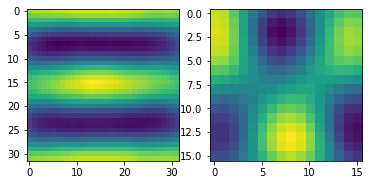

In [64]:
i = 90

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(pcm_bases[1][i].reshape((32, 32)))
ax2.imshow(pcm_bases[0][i].reshape((16, 16)))